In [9]:
%reload_ext autoreload
%autoreload 2

In [10]:
import autorootcwd
import os

import torch

from src.models.crnn import get_model
from src.utils import get_torch_device, id_to_chord_map, get_chord_annotation, HOP_LENGTH, SR

frame_to_secs = lambda x: round(x * (HOP_LENGTH / SR), 2)

def chord_frames_to_sequence(pred_classes):
    """
    Returns a sequence of tuples of chord and when the chord starts in seconds
    """
    chords = []
    counter = 0
    chord_start = 0
    for i, c in enumerate(pred_classes[:-1]):
        counter += 1
        if c != pred_classes[i+1]:
            chords.append((c, frame_to_secs(chord_start)))
            chord_start = counter
    chords.append((pred_classes[-1], frame_to_secs(chord_start)))
    return chords

In [38]:
model = get_model(hmm=False)
model_smooth = get_model(hmm=True, hmm_alpha=0.2)
device = get_torch_device()
DIR = 'data/processed'
filename = "raycharles_eleanorrigby"
cqt = torch.load(f"{DIR}/cache/4096/cqts/{filename}.pt", weights_only=True) 

In [37]:
preds = model.predict(cqt.unsqueeze(0).to(device))
preds_smooth = model_smooth.predict(cqt.unsqueeze(0).to(device))
true_chords = get_chord_annotation(filename, frame_length=4096/44100)

In [ ]:
# pred_chords = [id_to_chord_map[pred] for pred in preds]
# pred_seq = chord_frames_to_sequence(pred_chords)
# pred_chords_smooth = [id_to_chord_map[pred] for pred in preds_smooth]
# pred_seq_smooth = chord_frames_to_sequence(pred_chords_smooth)
# print(pred_seq)
# print(pred_seq_smooth)
# print(true_seq)

[('E:min', 0.0), ('N', 0.19), ('E:min', 0.28), ('C:maj7', 4.37), ('E:min', 4.46), ('C:maj', 9.2), ('C:7', 9.29), ('C:maj', 9.94), ('C:7', 11.52), ('C:maj7', 11.8), ('E:min', 13.1), ('C:maj', 17.55), ('C:7', 18.02), ('C:maj', 18.85), ('C:7', 18.95), ('D#:dim7', 19.69), ('C:7', 19.88), ('C:maj7', 20.25), ('E:min', 21.36), ('E:min7', 21.73), ('E:min', 23.31), ('E:min7', 23.41), ('E:min', 23.5), ('E:min6', 24.89), ('E:min', 25.73), ('C:maj7', 25.91), ('E:min', 26.38), ('C:maj', 26.94), ('E:min', 27.86), ('E:min7', 29.72), ('E:min', 31.39), ('E:min6', 33.81), ('E:min', 34.09), ('C:maj7', 34.64), ('C:maj', 36.04), ('C:maj7', 36.22), ('E:min', 36.5), ('C:maj7', 37.52), ('E:min', 37.89), ('C:maj7', 37.99), ('C:maj', 38.17), ('C:7', 38.36), ('C:maj7', 42.35), ('E:min', 43.1), ('A:min7', 46.44), ('A:min', 48.39), ('A:7', 49.69), ('A:min', 49.78), ('E:min', 50.9), ('C:maj7', 59.16), ('C:maj', 59.35), ('C:maj7', 59.81), ('E:min', 63.07), ('C:maj', 67.43), ('C:maj7', 68.17), ('D#:dim7', 69.66), ('C

### Make it Pretty!

In [33]:
from functools import lru_cache
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import colorsys
import random
from matplotlib.ticker import FuncFormatter

from src.utils import chord_to_id, id_to_chord, chord_to_id_map

##############################################################################
# 1) Utility to convert from large-vocab ID to small-vocab ID
##############################################################################
@lru_cache(maxsize=None)
def large_to_small_vocab_id(ch_id: int) -> int:
    """
    Converts a large vocabulary chord id to a small vocabulary chord id.
    """
    chord = id_to_chord(ch_id, use_small_vocab=False)
    return chord_to_id(chord, use_small_vocab=True)

##############################################################################
# 2) Helper function to clip chord intervals to [start_time, end_time],
#    but do NOT shift times (i.e., no rebase).
##############################################################################
def slice_chords_no_rebase(chords, start_time, end_time):
    """
    chords: list of (chord_id, chord_abs_start)

    Convert each chord to (chord_id, chord_abs_start, chord_abs_end),
    and clip to [start_time, end_time], but do NOT shift times to zero.
    """
    intervals = []
    for i, (cid, cstart) in enumerate(chords):
        # End time from next chord or +2 if last
        if i < len(chords) - 1:
            cend = chords[i + 1][1]
        else:
            cend = cstart + 2.0

        # Overlap with [start_time, end_time]?
        if cend >= start_time and cstart <= end_time:
            clipped_start = max(cstart, start_time)
            clipped_end   = min(cend, end_time)
            if clipped_end > clipped_start:
                intervals.append((cid, clipped_start, clipped_end))
    return intervals

##############################################################################
# 3) Main plotting function
##############################################################################
def plot_chord_block(
    chord_sequences_dict,
    window=None,
    title=None,
    width_per_second=0.4,
    draw_chord_change_lines=True,
    save_as=None,
    seed=0
):
    """
    chord_sequences_dict: { "True": [(cid, st), ...], "Predicted": [...], ... }
    window: (start_t, end_t) to clip & display. We do *not* shift to zero,
            so the x-axis is in absolute time.
    title: optional bold, centered title
    width_per_second: width scaling in inches per second
    seed: the random seed for shuffling color permutation
    """

    new_chord_sequences_dict = {}
    for label, seq in chord_sequences_dict.items():
        # If seq is a tensor
        if torch.is_tensor(seq):
            seq = seq.squeeze().cpu().numpy()
        # Convert to chord ids
        seq_chords = [id_to_chord_map[c] for c in seq]
        # Convert to chord sequence
        seq = chord_frames_to_sequence(seq_chords)
        new_chord_sequences_dict[label] = seq
        
    chord_sequences_dict = new_chord_sequences_dict

    # --------------------------------------------------------------------------
    # A) Build color palette locally so that it depends on seed
    # --------------------------------------------------------------------------
    NUM_SMALL_CHORDS = 26

    # Build a permutation [0..25]
    perm = list(range(NUM_SMALL_CHORDS))
    random.seed(seed)
    random.shuffle(perm)

    # Now create a color list of length 26, permuting the hue steps.
    colors_26 = []
    for i in range(NUM_SMALL_CHORDS):
        j = perm[i]
        hue = j / NUM_SMALL_CHORDS
        s = 0.5
        
        v = 1.0
        r, g, b = colorsys.hsv_to_rgb(hue, s, v)
        colors_26.append((r, g, b, 0.5))

    # A helper function that uses our local colors_26
    def get_small_vocab_color(large_id: int):
        sv_id = large_to_small_vocab_id(large_id)
        return colors_26[sv_id]

    # --------------------------------------------------------------------------
    # B) Identify the first chord sequence and prepare (x_min, x_max)
    # --------------------------------------------------------------------------
    # We'll want the chord change lines from the first sequence.
    # If Python 3.7+, dictionaries preserve insertion order, so "first" means
    # the first item in the dict. Otherwise, you can explicitly pick whichever key you want.
    first_label = list(chord_sequences_dict.keys())[0]
    first_seq   = chord_sequences_dict[first_label]

    # If user provides a window, use that as [x_min, x_max].
    # Otherwise, derive from chord data.
    if window is not None:
        x_min, x_max = window
    else:
        starts_ends = []
        for seq in chord_sequences_dict.values():
            for i, (cid, st) in enumerate(seq):
                if i < len(seq) - 1:
                    en = seq[i+1][1]
                else:
                    en = st + 2.0
                starts_ends.append(st)
                starts_ends.append(en)

        x_min = min(starts_ends) if starts_ends else 0.0
        x_max = max(starts_ends) if starts_ends else 0.0

    window_length = x_max - x_min
    if window_length <= 0:
        print("No valid window to display: end <= start.")
        return

    # --------------------------------------------------------------------------
    # C) Convert each chord sequence to intervals, clipped to [x_min, x_max]
    # --------------------------------------------------------------------------
    tracks = []
    for label, seq in chord_sequences_dict.items():
        if window is not None:
            intervals = slice_chords_no_rebase(seq, x_min, x_max)
        else:
            intervals = []
            for i, (cid, st) in enumerate(seq):
                if i < len(seq) - 1:
                    en = seq[i+1][1]
                else:
                    en = st + 2.0
                intervals.append((cid, st, en))
        tracks.append((label, intervals))

    # --------------------------------------------------------------------------
    # D) Plot each track
    # --------------------------------------------------------------------------
    num_tracks = len(tracks)
    fig_width  = max(1.0, width_per_second * window_length)
    fig_height = 1.5 * num_tracks
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # We'll define a small helper to draw chords in a row
    def plot_chord_rectangles(chords_3col, y_base, x_left, ax, label_text=None):
        """
        chords_3col: list of (chord_id, start_sec, end_sec)
        y_base: bottom of rectangle track
        x_left: left edge of the plot
        ax: matplotlib axes
        label_text: optional label to the left
        """
        for (chord, start_sec, end_sec) in chords_3col:
            chord_id = chord_to_id_map[chord]
            width = end_sec - start_sec
            color = get_small_vocab_color(chord_id)

            # Draw the rectangle
            rect = Rectangle(
                (start_sec, y_base),
                width,
                1.0,
                edgecolor=(0, 0, 0, 1.0),    # black edge, fully opaque
                facecolor=color,
            )
            ax.add_patch(rect)

            # Label with chord's name if wide enough
            if width >= 0.8:
                chord_name = id_to_chord(chord_id, use_small_vocab=False)
                ax.text(
                    start_sec + width/2,
                    y_base + 0.5,
                    chord_name,
                    ha='center',
                    va='center'
                )

        if label_text is not None:
            # Slightly left of the track
            ax.text(
                x_left - 0.2,
                y_base + 0.5,
                label_text,
                ha='right',
                va='center',
                style='italic'
            )

    # Plot from top (track 0) down
    for i, (label, intervals) in enumerate(tracks):
        y_base = -i
        plot_chord_rectangles(intervals, y_base, x_min, ax, label_text=label)

    # --------------------------------------------------------------------------
    # E) Draw vertical lines for chord changes in the *first* chord sequence
    # --------------------------------------------------------------------------
    # Typically, the "change" is each chord's start time.
    # We'll only draw lines within our [x_min, x_max] window.
    if draw_chord_change_lines:
        for (chord_id, chord_start) in first_seq:
            if x_min <= chord_start <= x_max:
                ax.axvline(chord_start, color='black', linestyle='--', linewidth=0.8, alpha=0.8, zorder=-1)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(- (num_tracks - 1), 1)

    # --------------------------------------------------------------------------
    # F) Format x-axis in mm:ss
    # --------------------------------------------------------------------------
    # Place ticks every 5 seconds (or 10, etc.) from x_min to x_max
    tick_start = int(np.floor(x_min / 5.0)) * 5
    tick_end   = int(np.ceil(x_max / 5.0)) * 5
    major_ticks = list(range(tick_start, tick_end + 1, 5))
    # Filter out-of-range
    major_ticks = [t for t in major_ticks if t >= x_min and t <= x_max]

    ax.set_xticks(major_ticks)

    def format_mmss(x, pos):
        """Convert x (seconds) -> mm:ss."""
        m = int(x // 60)
        s = int(x % 60)
        return f"{m}:{s:02d}"

    ax.xaxis.set_major_formatter(FuncFormatter(format_mmss))

    # Draw vertical lines (light) at each major tick
    # for t in major_ticks:
    #     ax.axvline(t, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

    ax.set_yticks([])
    # ax.set_xlabel("Time (mm:ss)")

    if title:
        ax.set_title(title, ha='center', pad=15, fontsize=16)

    plt.tight_layout()

    if save_as is not None:
        plt.savefig(f'./thesis/figures/{save_as}.png', dpi=200, bbox_inches='tight')
    plt.show()


### Actually Draw!

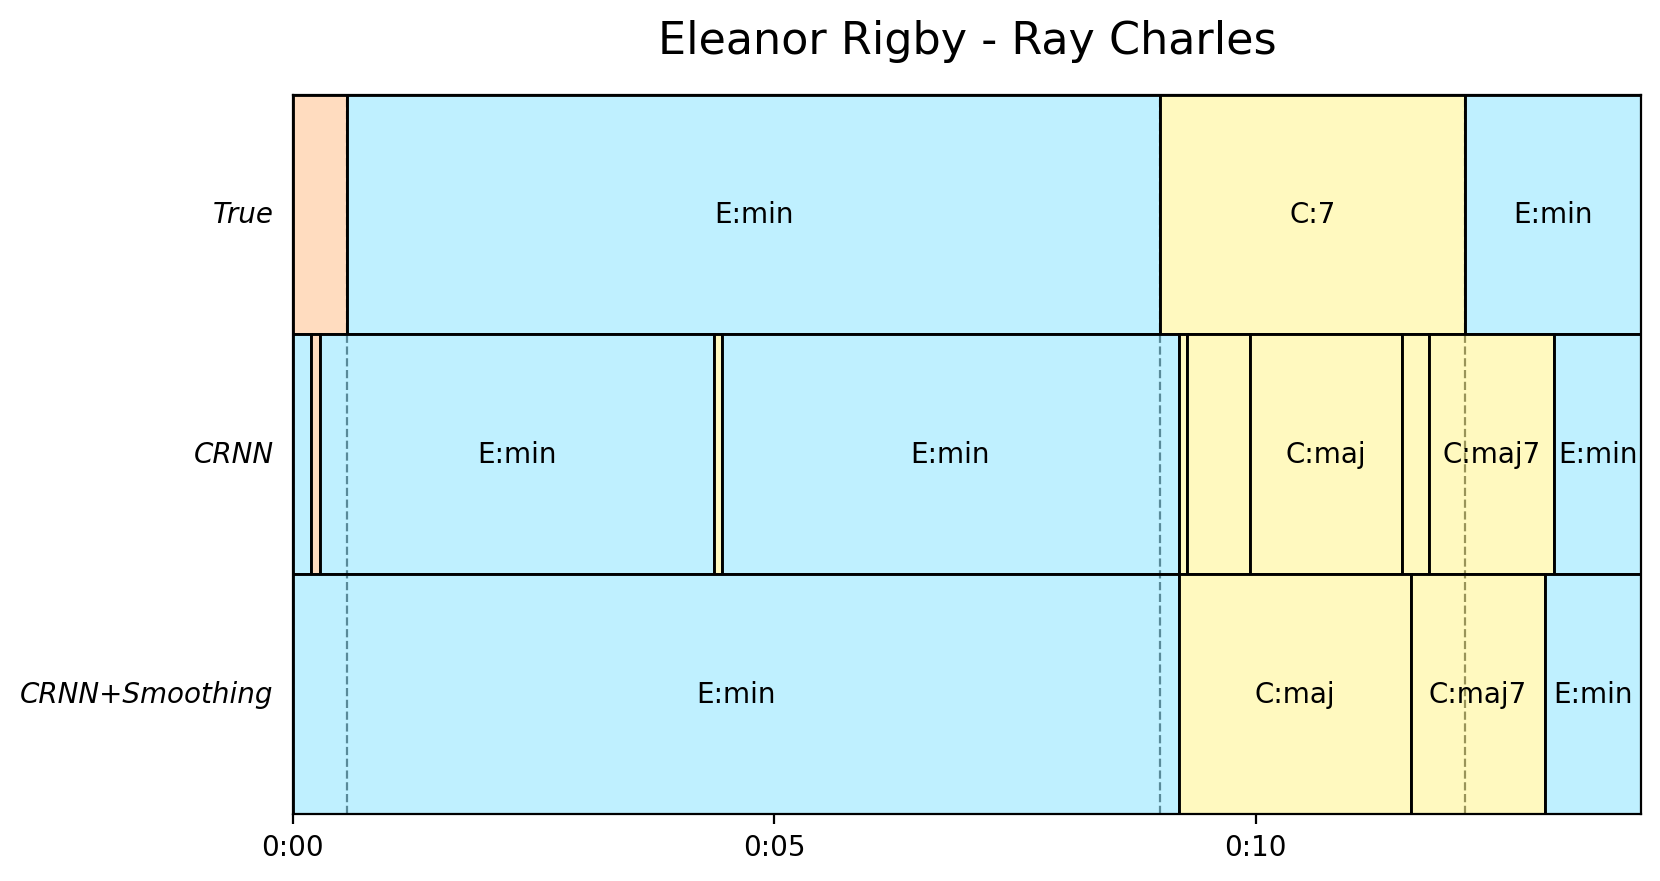

In [34]:
plot_chord_block(
    {
        "True": true_chords,
        "CRNN": preds,
        "CRNN+Smoothing": preds_smooth
    },
    window=(0, 14),
    width_per_second=0.6,
    title="Eleanor Rigby - Ray Charles",
    draw_chord_change_lines=True,
    save_as='hmm_smoothing_example',
    seed=5
)
